In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import pandas as pd

C:\Users\Ethan\AppData\Roaming\Python\Python39\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train = pd.read_csv('../TrainTestData/com_train.csv').sample(1000)
test = pd.read_csv('../TrainTestData/com_test.csv').sample(1000)

x = train.iloc[:,:35]
y = train.iloc[:,35]
x_val = test.iloc[:,:35]
y_val = test.iloc[:,35]

temp = x.astype('float32')
x = temp.copy()

temp_val = x_val.astype('float32')
x_val = temp_val.copy()

y = y.values
y = y.reshape(-1,1)
y_val = y_val.values
y_val = y_val.reshape(-1,1)

# Cast to float32
x = x.astype('float32')
y = y.astype('float32')

In [3]:
# Settings
D = 35   #number of dimensions
N = 1000 #number of datapoints to generate
EPOCHS = 300
BATCH_SIZE = 50
L_RATE = 0.02

# Make a TensorFlow Dataset from training data
data_train = tf.data.Dataset.from_tensor_slices(
    (x, y)).shuffle(10000).batch(BATCH_SIZE)

In [4]:
class BayesianLinearRegression(tf.keras.Model):


    def __init__(self, d, name=None):
        super(BayesianLinearRegression, self).__init__(name=name)
        self.w_loc = tf.Variable(tf.random.normal([d, 1]), name='w_loc')
        self.w_std = tf.Variable(tf.random.normal([d, 1]), name='w_std')
        self.b_loc = tf.Variable(tf.random.normal([1]), name='b_loc')
        self.b_std = tf.Variable(tf.random.normal([1]), name='b_std')
        self.s_alpha = tf.Variable(tf.exp(tf.random.normal([1])), name='s_alpha')
        self.s_beta = tf.Variable(tf.exp(tf.random.normal([1])), name='s_beta')
    
    
    @property
    def weight(self):
        """Variational posterior for the weight"""
        return tfd.Normal(self.w_loc, tf.exp(self.w_std))
    
    
    @property
    def bias(self):
        """Variational posterior for the bias"""
        return tfd.Normal(self.b_loc, tf.exp(self.b_std))


    @property
    def std(self):
        """Variational posterior for the noise standard deviation"""
        return tfd.InverseGamma(tf.exp(self.s_alpha), tf.exp(self.s_beta))

    
    def call(self, x, sampling=True):
        """Predict p(y|x)"""
        sample = lambda x: x.sample() if sampling else x.mean()
        loc = x @ sample(self.weight) + sample(self.bias)
        std = tf.sqrt(sample(self.std))
        return tfd.Normal(loc, std)
    
    
    @property
    def losses(self):
        """Sum of KL divergences between posteriors and priors"""
        prior = tfd.Normal(0, 1)
        return (tf.reduce_sum(tfd.kl_divergence(self.weight, prior)) +
                tf.reduce_sum(tfd.kl_divergence(self.bias, prior)))

In [5]:
model = BayesianLinearRegression(D)

In [6]:
optimizer = tf.keras.optimizers.Adam(lr=L_RATE)

@tf.function
def train_step(x_data, y_data):
    with tf.GradientTape() as tape:
        log_prob = tf.reduce_mean(model(x_data).log_prob(y_data))
        kl_loss = model.losses/N
        elbo_loss = kl_loss - log_prob
    gradients = tape.gradient(elbo_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

D:\Anaconda\envs\GPU3090\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [7]:
from tensorflow.python.ops.numpy_ops import np_config

np_config.enable_numpy_behavior()

In [8]:
# Fit the model
for epoch in range(EPOCHS):
    
    # Update weights each batch
    for x_data, y_data in data_train:
        x_data = x_data.astype('float32')
        y_data = y_data.astype('float32')
        train_step(x_data, y_data)

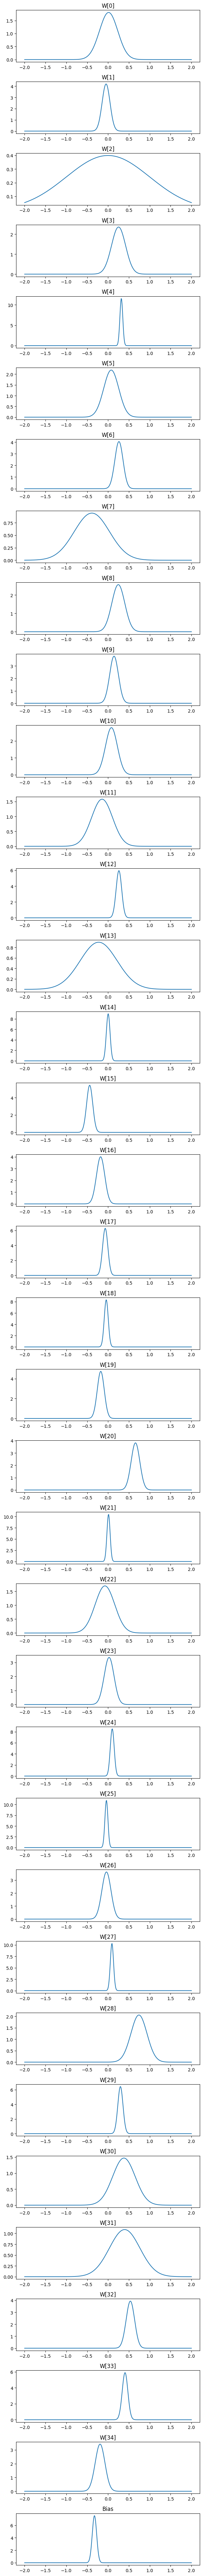

In [9]:
fig = plt.figure()
fig.set_size_inches(6.4, 80)
v = np.linspace(-2, 2, 400)

# Plot weight posteriors
probs = model.weight.prob(v*np.ones([D, 1]))
for i in range(D):
    plt.subplot(D+1, 1, i+1)
    plt.plot(v, probs[i, :])
    plt.title('W[{}]'.format(i))
    
# Plot Bias posterior
plt.subplot(D+1, 1, D+1)
plt.plot(v, model.bias.prob(v))
plt.title('Bias')

plt.tight_layout()
plt.show()